In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import random
import time

# Inside the /Multimodal-Deep-Regression/notebooks
import sys
sys.path.append("..")

from util.utilities import train, evaluate, get_device
from util.data_utilities import get_base_tensor_directories, generate_batch
from util.data_utilities import process_data

# import all the models from models module
from models import CNN3D

In [2]:
# Current Path
os.getcwd()

'/home/louis/Documents/gatech/Summer2023/Multimodal-Deep-Regression/notebooks'

In [3]:
device = get_device()
x_dir, y_dir = get_base_tensor_directories(input_type='video_pack_1000')

x_files = sorted([os.path.join(x_dir, f) for f in os.listdir(x_dir)])
y_files = sorted([os.path.join(y_dir, f) for f in os.listdir(y_dir)])

You are using device: cuda


In [4]:
x_data = [torch.load(f) for f in x_files]
y_data = [torch.load(f) for f in y_files]

In [5]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
print(x_train[0].size())
print(x_val[0].size())
print(len(y_train))
print(len(y_val))

torch.Size([3, 3, 1024, 576])
torch.Size([3, 2, 1024, 576])
16
4


In [6]:
[i.shape for i in x_data]

[torch.Size([3, 3, 1024, 576]),
 torch.Size([3, 4, 1024, 576]),
 torch.Size([3, 6, 1024, 576]),
 torch.Size([3, 2, 1024, 576]),
 torch.Size([3, 5, 1024, 576]),
 torch.Size([3, 3, 1024, 576]),
 torch.Size([3, 2, 1024, 576]),
 torch.Size([3, 3, 1024, 576]),
 torch.Size([3, 8, 1024, 576]),
 torch.Size([3, 7, 1024, 576]),
 torch.Size([3, 2, 768, 576]),
 torch.Size([3, 5, 1024, 576]),
 torch.Size([3, 12, 1024, 576]),
 torch.Size([3, 4, 1024, 576]),
 torch.Size([3, 3, 1018, 576]),
 torch.Size([3, 4, 1246, 576]),
 torch.Size([3, 2, 1024, 576]),
 torch.Size([3, 17, 1024, 576]),
 torch.Size([3, 6, 1024, 576]),
 torch.Size([3, 36, 1024, 576])]

In [7]:
# Create Batches with DataLoaders
batch_size = 1
train_loader = list(zip(x_train, y_train)) #TensorDataset(x_train, y_train)
val_loader = list(zip(x_val, y_val)) #TensorDataset(x_val, y_val)
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False, collate_fn=generate_batch)

In [8]:
model = CNN3D()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())#, lr=0.01)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

EPOCHS = 20

train_losses = []
val_losses = []
start_time = time.time()

for epoch in range(EPOCHS):
    train_loss, avg_train_loss = train(model, train_loader, criterion, optimizer, device, verbose=False)
    val_loss, avg_val_loss = evaluate(model, val_loader, criterion, device, verbose=False)
    
    # record the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print every num times epoch only
    num = 1
    if ((epoch+1) % num == 0) or epoch == 0:
        if epoch == 0:
            time_took = (time.time() - start_time) / 60
            print(f'First epoch took {time_took:.1f} minutes.')
        print(f'Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}')


Total parameters: 9,438,497
First epoch took 0.2 minutes.
Epoch 1/20, Train_Loss: 454488849221.25, Avg: 28405553076.33; Val_Loss: 7539466624.00, Avg: 1884866656.00
Epoch 2/20, Train_Loss: 37663260358.25, Avg: 2353953772.39; Val_Loss: 1417470192.00, Avg: 354367548.00
Epoch 3/20, Train_Loss: 7390896193.67, Avg: 461931012.10; Val_Loss: 648645188.00, Avg: 162161297.00
Epoch 4/20, Train_Loss: 6486481693.00, Avg: 405405105.81; Val_Loss: 595014930.00, Avg: 148753732.50
Epoch 5/20, Train_Loss: 4933919273.31, Avg: 308369954.58; Val_Loss: 341001882.00, Avg: 85250470.50
Epoch 6/20, Train_Loss: 4120738905.49, Avg: 257546181.59; Val_Loss: 268577280.00, Avg: 67144320.00
Epoch 7/20, Train_Loss: 3636992975.19, Avg: 227312060.95; Val_Loss: 371746369.00, Avg: 92936592.25
Epoch 8/20, Train_Loss: 3023806956.29, Avg: 188987934.77; Val_Loss: 343082146.00, Avg: 85770536.50
Epoch 9/20, Train_Loss: 2443600895.43, Avg: 152725055.96; Val_Loss: 300055522.00, Avg: 75013880.50
Epoch 10/20, Train_Loss: 1989865414.86

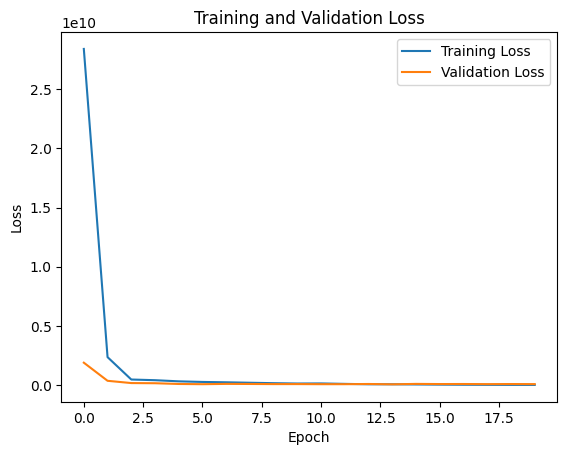

In [9]:
import matplotlib.pyplot as plt

# lost plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [10]:
# compare to validation set
val_values = []
predicted_values = []

for inputs, targets in val_loader:
    inputs, targets = inputs.to(torch.float32), targets.to(torch.float32)

    # Forward pass
    outputs = model(inputs).squeeze(1)
    print(targets)
    print(outputs)
    # Append the values
    val_values.append(float(targets.squeeze()))
    predicted_values.append(float(outputs.squeeze()))
    

tensor([1800.])
tensor([14667.0059], grad_fn=<SqueezeBackward1>)
tensor([45.5000])
tensor([-2005.4935], grad_fn=<SqueezeBackward1>)
tensor([4000.])
tensor([-6548.8027], grad_fn=<SqueezeBackward1>)
tensor([63.7000])
tensor([3754.6562], grad_fn=<SqueezeBackward1>)


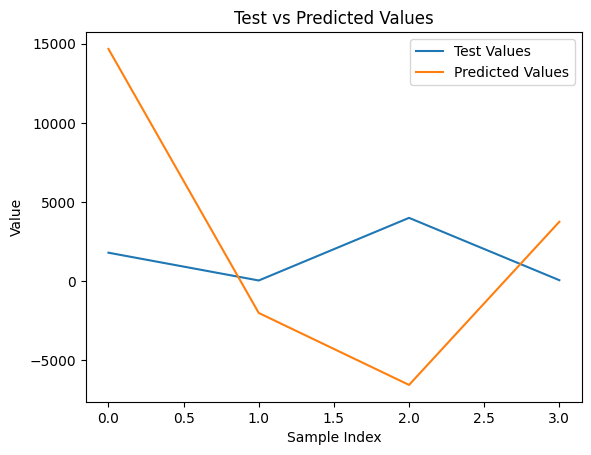

In [11]:
import matplotlib.pyplot as plt

plt.plot(val_values, label='Test Values')
plt.plot(predicted_values, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test vs Predicted Values')
plt.legend()
plt.show()

In [12]:
val_values, predicted_values

([1800.0, 45.5, 4000.0, 63.70000076293945],
 [14667.005859375, -2005.4935302734375, -6548.802734375, 3754.65625])